<a href="https://colab.research.google.com/github/shrprabh/BraTS-PolypSegmentation/blob/optimized-and-best-predicted-model/polysegmentationofbradtsdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install nibabel for handling NIfTI files


In [1]:
!pip install nibabel

# Import libraries


In [2]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Conv2DTranspose,
                                     BatchNormalization, Activation, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# importing files files package to upload a file to get the dataset

In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shrprabh","key":"323ee59f3e2f0c11df48be77bdb30712"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d awsaf49/brats2020-training-data


Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats2020-training-data
License(s): CC0-1.0
100% 6.75G/6.76G [05:49<00:00, 21.5MB/s]
100% 6.76G/6.76G [05:49<00:00, 20.7MB/s]


In [5]:
!kaggle datasets download -d awsaf49/brats2020-training-data
!unzip -qq brats2020-training-data.zip -d brats2020


Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats2020-training-data
License(s): CC0-1.0
brats2020-training-data.zip: Skipping, found more recently modified local copy (use --force to force download)


#Step 3: Data Preprocessing
#Load the images and masks, extract slices, and prepare them for training.#

#load libraries

In [ ]:
import os
import h5py
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose,
                                     BatchNormalization, Activation, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Nov 30 07:11:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              41W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Define your data directory



In [ ]:
data_dir = 'brats2020/BraTS2020_training_data/content/data/'


# Initialize lists to store image and mask slices


Input images shape (X): (432, 256, 256, 4)
Mask images shape (y): (432, 256, 256, 1)
Training images shape (X_train): (345, 256, 256, 4)
Training masks shape (y_train): (345, 256, 256, 1)
Validation images shape (X_val): (87, 256, 256, 4)
Validation masks shape (y_val): (87, 256, 256, 1)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 256, 256, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_255 (Conv2D)       │ (None, 256, 256, 32)   │          1,184 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_243   │ (None, 256, 256, 32)   │            128 │ conv2d_255[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_243            │ (None, 256, 256, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_198           │ (None, 256, 256, 36)   │              0 │ input_layer_12[0][0],  │
│ (Concatenate)             │                        │                │ activation_243[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_256 (Conv2D)       │ (None, 256, 256, 32)   │         10,400 │ concatenate_198[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_244   │ (None, 256, 256, 32)   │            128 │ conv2d_256[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_244            │ (None, 256, 256, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_199           │ (None, 256, 256, 68)   │              0 │ input_layer_12[0][0],  │
│ (Concatenate)             │                        │                │ activation_243[0][0],  │
│                           │                        │                │ activation_244[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_257 (Conv2D)       │ (None, 256, 256, 32)   │         19,616 │ concatenate_199[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_245   │ (None, 256, 256, 32)   │            128 │ conv2d_257[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_245            │ (None, 256, 256, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_36          │ (None, 128, 128, 32)   │              0 │ activation_245[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_258 (Conv2D)       │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_36[0][0] │
├──────────────────────

 Total params: 21,900,737 (83.54 MB)

 Trainable params: 21,891,905 (83.51 MB)

 Non-trainable params: 8,832 (34.50 KB)

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9336 - loss: 0.3792
Epoch 1: val_loss improved from inf to 0.53312, saving model to ducknet_brats.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 39s 266ms/step - accuracy: 0.9342 - loss: 0.3774 - val_accuracy: 0.9715 - val_loss: 0.5331
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9865 - loss: 0.1886
Epoch 2: val_loss improved from 0.53312 to 0.43265, saving model to ducknet_brats.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - accuracy: 0.9866 - loss: 0.1884 - val_accuracy: 0.9755 - val_loss: 0.4327
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9869 - loss: 0.1600
Epoch 3: val_loss improved from 0.43265 to 0.40949, saving model to ducknet_brats.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.9869 - loss: 0.1599 - val_accuracy: 0.9780 - val_loss: 0.4095
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9883 - loss: 0.1353
Epoch 4: val_loss improved from 0.40949 to 

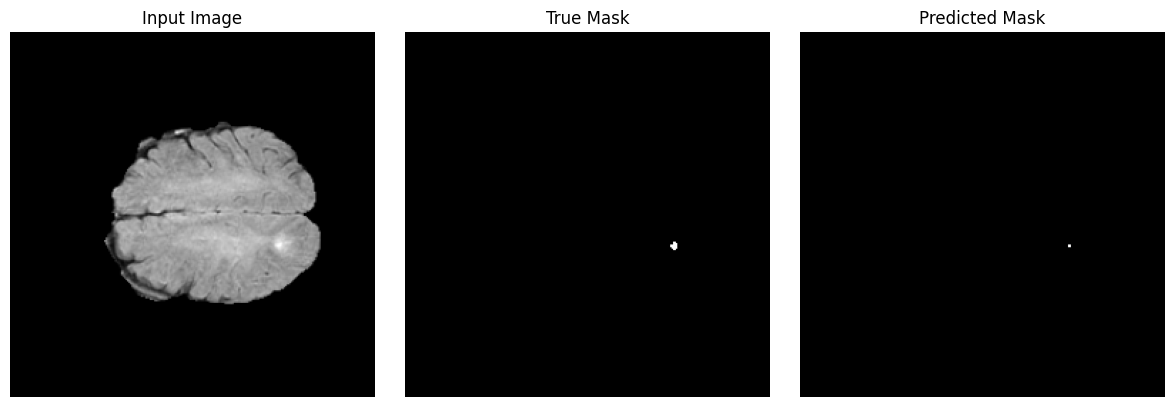

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


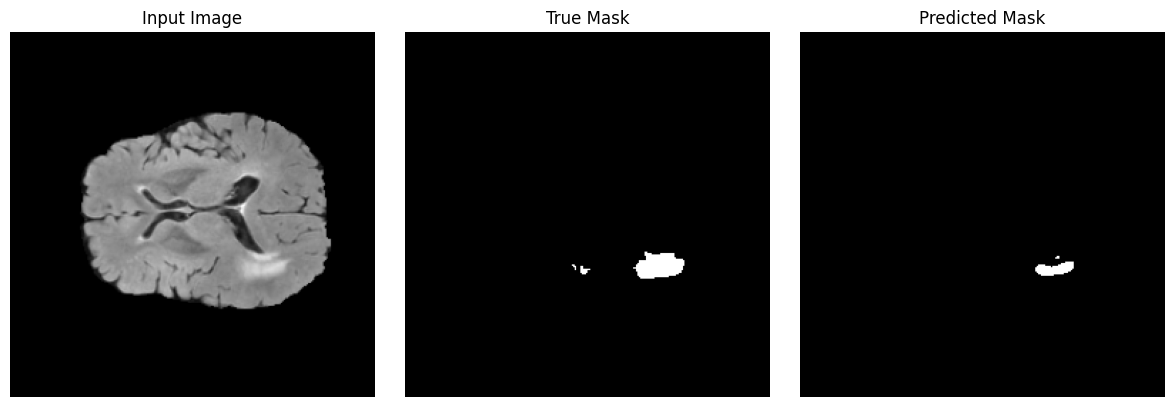

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


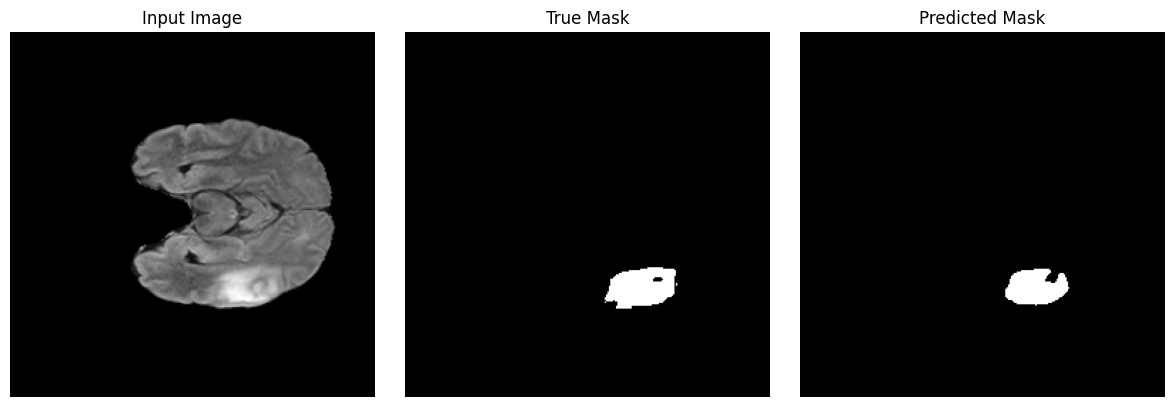

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


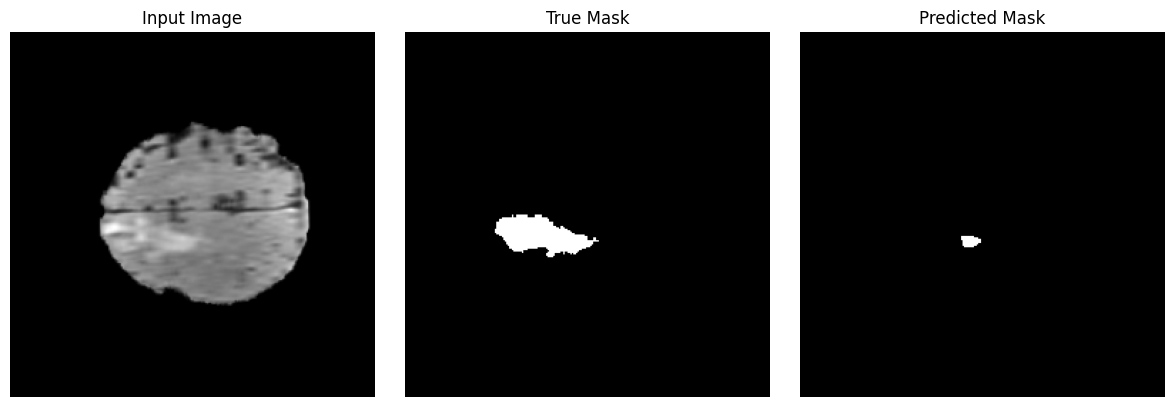

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


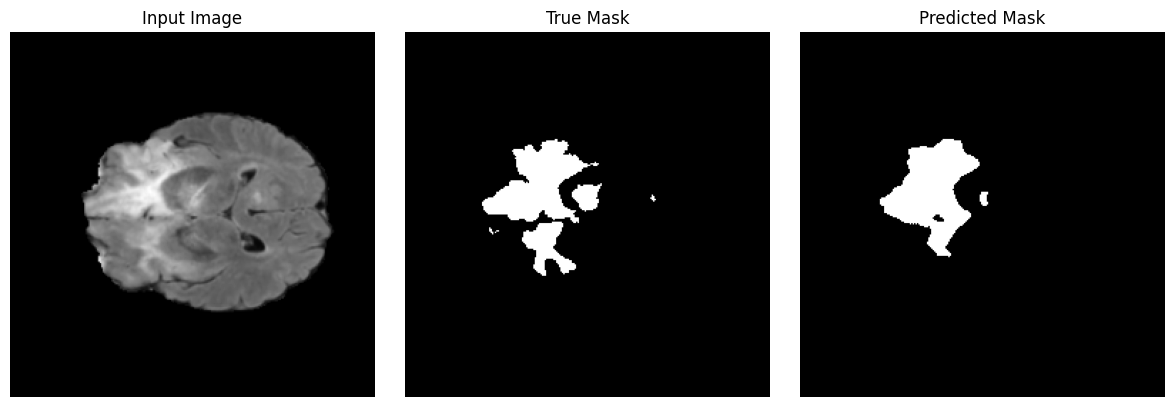

In [42]:
import os
import numpy as np
import h5py
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Conv2DTranspose,
                                     BatchNormalization, Activation, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Check for GPU availability
if not tf.config.list_physical_devices('GPU'):
    print("No GPU found. Training will be slow.")

# Define the data directory and initialize lists for images and masks
data_dir = 'brats2020/BraTS2020_training_data/content/data/'  # Update this path as needed
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"The data directory {data_dir} does not exist.")

image_slices = []
mask_slices = []

# Load and preprocess data
file_list = [f for f in os.listdir(data_dir) if f.endswith('.h5')][:5000]
for file_name in file_list:
    file_path = os.path.join(data_dir, file_name)
    with h5py.File(file_path, 'r') as f:
        img_slice = np.array(f['image'])
        mask_slice = np.array(f['mask'])

        # Skip slices without any mask
        if np.max(mask_slice) == 0:
            continue

        # Normalize the image slice
        epsilon = 1e-8
        img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min() + epsilon)

        # Resize images and masks to 256x256
        img_resized = cv2.resize(img_slice, (256, 256), interpolation=cv2.INTER_LINEAR)
        mask_resized = cv2.resize(mask_slice, (256, 256), interpolation=cv2.INTER_NEAREST)

        # Convert masks to single-channel binary
        if mask_resized.ndim == 3:
            mask_resized = np.any(mask_resized, axis=-1).astype(np.float32)

        # Expand dimensions for images if necessary
        if img_resized.ndim == 2:
            img_resized = np.expand_dims(img_resized, axis=-1)

        # Expand dimensions for masks if necessary
        if mask_resized.ndim == 2:
            mask_resized = np.expand_dims(mask_resized, axis=-1)

        image_slices.append(img_resized)
        mask_slices.append(mask_resized)

# Convert lists to numpy arrays
X = np.array(image_slices, dtype=np.float32)
y = np.array(mask_slices, dtype=np.float32)

# Debugging: Print data shapes
print(f"Input images shape (X): {X.shape}")
print(f"Mask images shape (y): {y.shape}")

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Debugging: Print split data shapes
print(f"Training images shape (X_train): {X_train.shape}")
print(f"Training masks shape (y_train): {y_train.shape}")
print(f"Validation images shape (X_val): {X_val.shape}")
print(f"Validation masks shape (y_val): {y_val.shape}")

# Data augmentation settings
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True,
                     rotation_range=90,
                     fill_mode='nearest')
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

# Define batch size
batch_size = 8

# Training generator function
def train_generator(X_train_data, y_train_data, batch_size):
    seed_value = 42
    image_generator = image_datagen.flow(X_train_data, batch_size=batch_size, seed=seed_value)
    mask_generator = mask_datagen.flow(y_train_data, batch_size=batch_size, seed=seed_value)
    while True:
        img = next(image_generator)
        mask = next(mask_generator)
        yield (img, mask)

train_gen = train_generator(X_train, y_train, batch_size=batch_size)

# Define DUCKNet architecture with dense blocks
def dense_block(x, filters):
    conv1 = Conv2D(filters, 3, padding='same')(x)
    bn1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(bn1)
    concat1 = Concatenate()([x, act1])
    conv2 = Conv2D(filters, 3, padding='same')(concat1)
    bn2 = BatchNormalization()(conv2)
    act2 = Activation('relu')(bn2)
    concat2 = Concatenate()([x, act1, act2])
    conv3 = Conv2D(filters, 3, padding='same')(concat2)
    bn3 = BatchNormalization()(conv3)
    act3 = Activation('relu')(bn3)
    return act3

def DUCKNet(input_size=(256, 256, 4)):  # Support 4-channel input
    inputs = Input(input_size)
    db1 = dense_block(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(db1)
    db2 = dense_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(db2)
    db3 = dense_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(db3)
    db4 = dense_block(pool3, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(db4)
    db5 = dense_block(pool4, 512)
    up6 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(db5)
    merge6 = Concatenate()([up6, db4])
    db6 = dense_block(merge6, 256)
    up7 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(db6)
    merge7 = Concatenate()([up7, db3])
    db7 = dense_block(merge7, 128)
    up8 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(db7)
    merge8 = Concatenate()([up8, db2])
    db8 = dense_block(merge8, 64)
    up9 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(db8)
    merge9 = Concatenate()([up9, db1])
    db9 = dense_block(merge9, 32)
    conv10 = Conv2D(1, 1, activation='sigmoid')(db9)
    model = Model(inputs=inputs, outputs=conv10)
    return model

# Build the model with input size adjusted for 4-channel input
model = DUCKNet(input_size=(256, 256, 4))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()

# Set up callbacks
callbacks = [
    ModelCheckpoint('ducknet_brats.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True, verbose=1)
]

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=300,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

# Visualize Predictions
import random
num_samples = 5
indices = random.sample(range(X_val.shape[0]), num_samples)
for i in indices:
    input_image = X_val[i]
    true_mask = y_val[i]
    prediction = model.predict(input_image[np.newaxis, ...])[0, :, :, 0]
    prediction = (prediction > 0.5).astype(np.float32)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(input_image[:, :, 0], cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(true_mask[:, :, 0], cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(prediction, cmap="gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [45]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Calculates the Dice Coefficient.

    Args:
        y_true (tensor): Ground truth mask.
        y_pred (tensor): Predicted mask.
        smooth (float): Smoothing factor to avoid division by zero.

    Returns:
        float: Dice Coefficient score.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [46]:
# Recompile the model to include the Dice Coefficient
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', dice_coefficient])


In [47]:
# Set up additional callbacks for better training management
from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('ducknet_brats_best.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# Calculate steps per epoch
steps_per_epoch = len(X_train) // batch_size

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=160,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)


Epoch 1/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9899 - dice_coefficient: 0.5340 - loss: 0.0452
Epoch 1: val_loss improved from inf to 0.05386, saving model to ducknet_brats_best.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 50s 499ms/step - accuracy: 0.9900 - dice_coefficient: 0.5339 - loss: 0.0452 - val_accuracy: 0.9914 - val_dice_coefficient: 0.4865 - val_loss: 0.0539 - learning_rate: 1.0000e-04
Epoch 2/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9904 - dice_coefficient: 0.5187 - loss: 0.0431
Epoch 2: val_loss did not improve from 0.05386
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9904 - dice_coefficient: 0.5189 - loss: 0.0431 - val_accuracy: 0.9923 - val_dice_coefficient: 0.5366 - val_loss: 0.0639 - learning_rate: 1.0000e-04
Epoch 3/160
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9906 - dice_coefficient: 0.5243 - loss: 0.0420
Epoch 3: val_loss improved from 0.05386 to 0.04490, saving model to ducknet_brats_best.keras
43/43 ━━━━━━━━━━━━━━━━

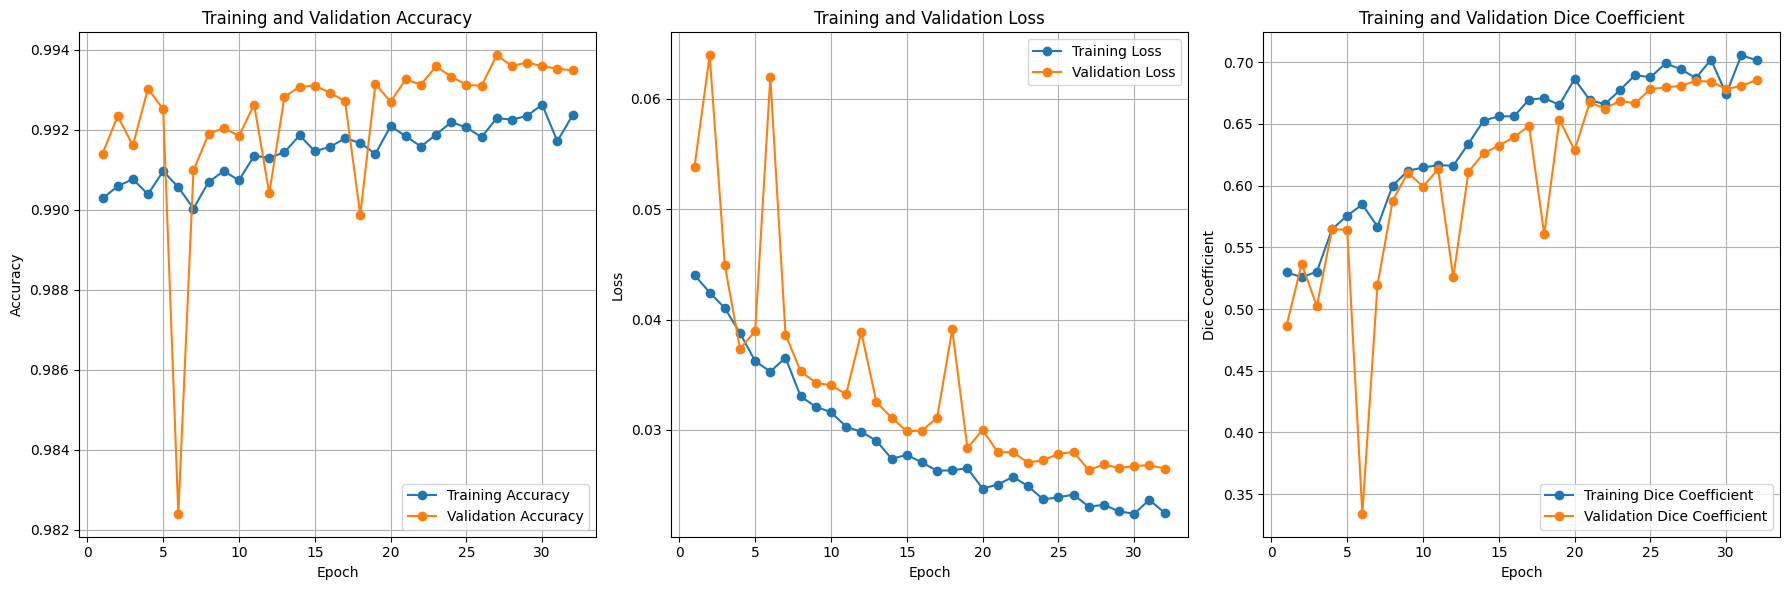

In [49]:
import matplotlib.pyplot as plt

# Retrieve metrics from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

dice = history.history['dice_coefficient']
val_dice = history.history['val_dice_coefficient']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(18, 6))

# Plot Accuracy
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Plot Dice Coefficient
plt.subplot(1, 3, 3)
plt.plot(epochs_range, dice, label='Training Dice Coefficient', marker='o')
plt.plot(epochs_range, val_dice, label='Validation Dice Coefficient', marker='o')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [28]:
files.download('ducknet_brats_best.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
import tensorflow as tf
from tensorflow.keras import backend as K

@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

@tf.keras.utils.register_keras_serializable()
def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    return bce + dl

@tf.keras.utils.register_keras_serializable()
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
import tensorflow as tf
from tensorflow.keras import backend as K

@tf.keras.utils.register_keras_serializable()
def iou_metric(y_true, y_pred, smooth=1):
    """
    Computes the Intersection over Union (IoU) metric.

    Args:
        y_true (tensor): Ground truth mask.
        y_pred (tensor): Predicted mask.
        smooth (float): Smoothing factor to avoid division by zero.

    Returns:
        float: IoU score.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [51]:
from tensorflow.keras.models import load_model

model = load_model(
    'ducknet_brats_best.keras',
    custom_objects={
        'dice_coefficient': dice_coefficient,
        'combined_loss': combined_loss,
        'dice_loss': dice_loss
    }
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


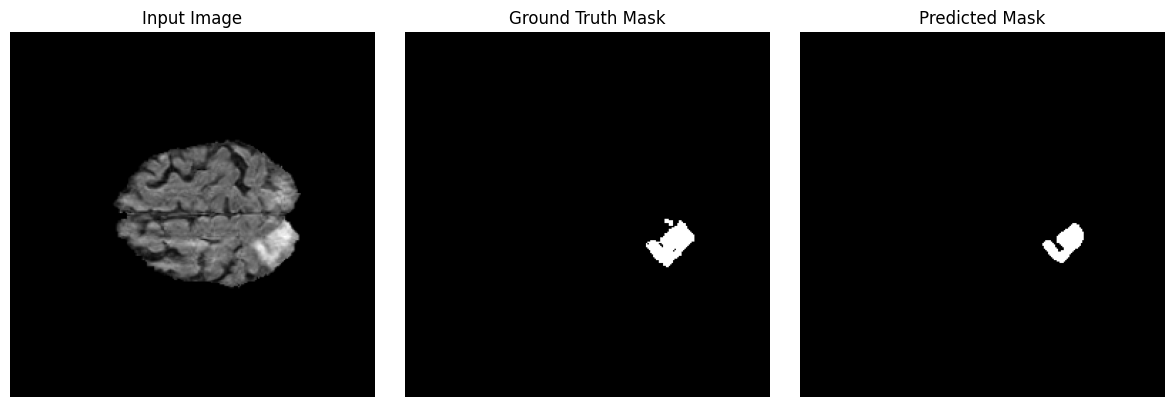

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


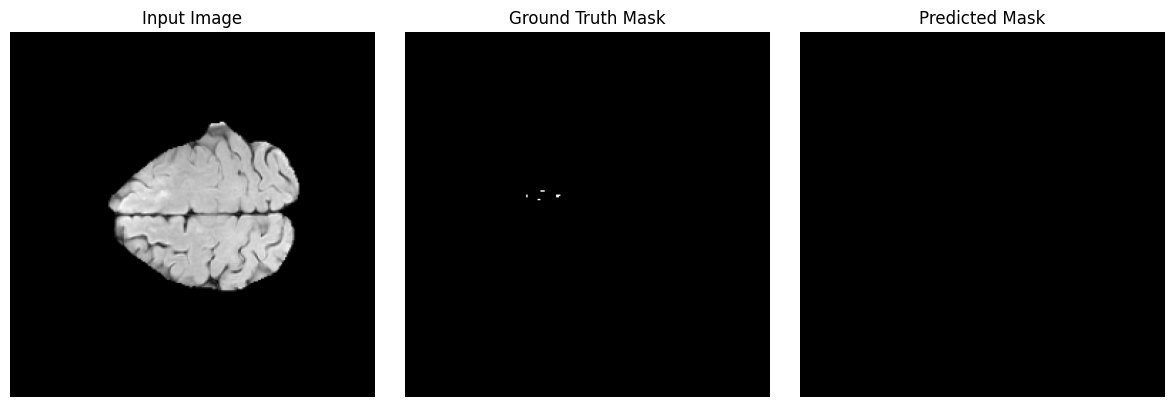

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


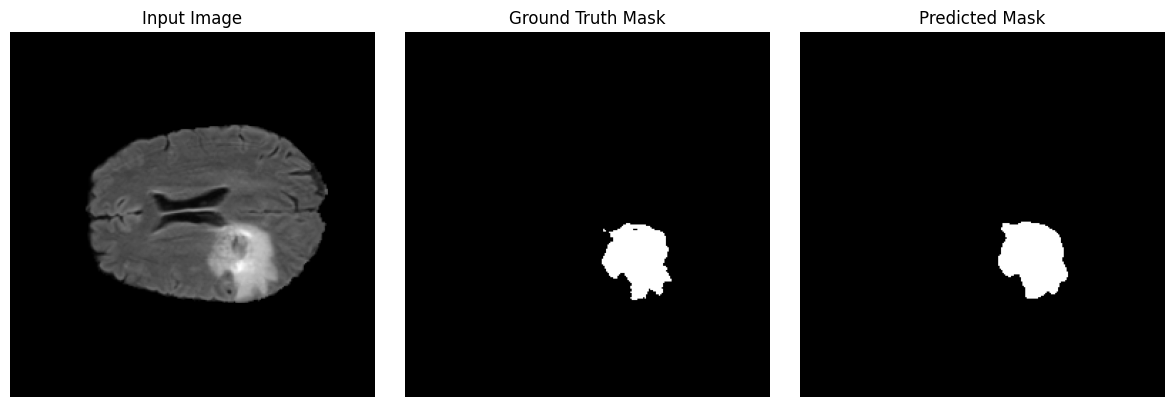

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


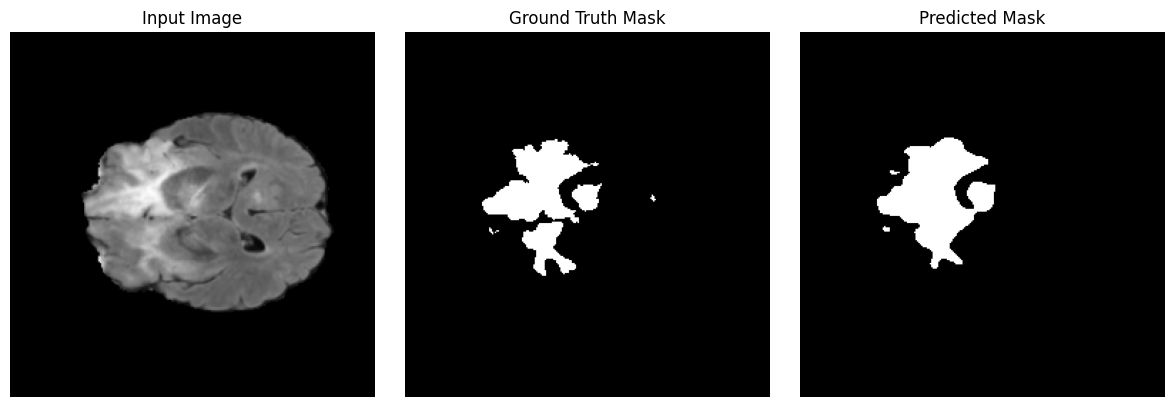

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


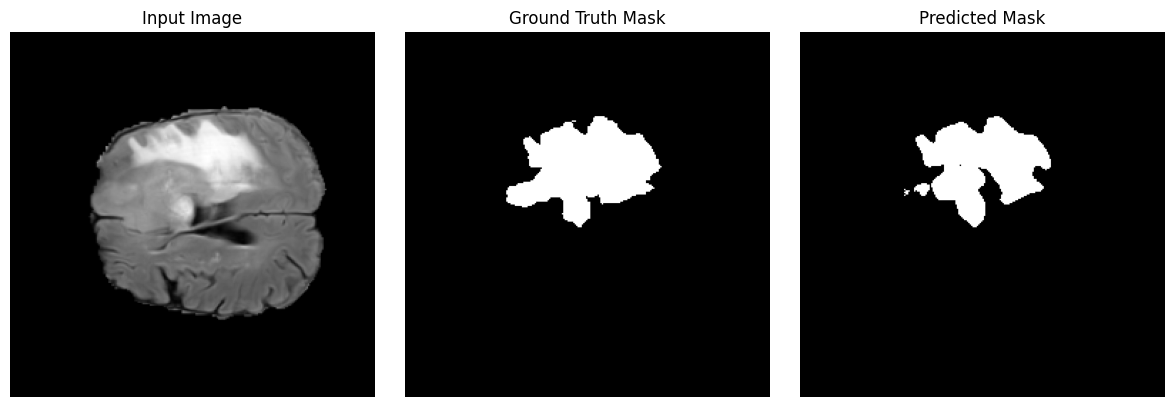

In [52]:
import random
import matplotlib.pyplot as plt

# Select a few random samples from the validation set
num_samples = 5  # Number of samples to visualize
random_indices = random.sample(range(X_val.shape[0]), num_samples)

# Iterate through selected samples
for idx in random_indices:
    # Get the input image, ground truth, and reshape for visualization
    input_image = X_val[idx]
    ground_truth_mask = y_val[idx]
    input_image_reshaped = input_image[:, :, 0] if input_image.shape[-1] > 1 else input_image[:, :, 0]

    # Add batch dimension and predict the mask
    input_image_batch = input_image[np.newaxis, ...]  # Add batch dimension
    predicted_mask = model.predict(input_image_batch)
    predicted_mask = predicted_mask[0, :, :, 0]  # Remove batch dimension and channel axis

    # Apply thresholding to the predicted mask
    predicted_mask = (predicted_mask > 0.5).astype(np.float32)

    # Display the image, ground truth, and prediction
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(input_image_reshaped, cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_mask[:, :, 0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
